# 🧠 Objective

In this notebook, we perform customer segmentation using unsupervised learning techniques.
The goal is to identify distinct groups of customers based on their purchasing behavior to
support business decisions like personalized marketing, pricing strategies, and product targeting.


# ✅ Setup

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pathlib import Path

In [2]:
# 📦 Connect to the database
db_path = Path("../data/WSDA_Music.db")
conn = sqlite3.connect(db_path)

# 📥 Query: Aggregate customer behavior

In [5]:
query_customer_features = """
SELECT c.customerid,
       c.firstname || ' ' || c.lastname AS customer_name,
       c.country,
       COUNT(DISTINCT i.invoiceid) AS total_invoices,
       SUM(il.unitprice * il.quantity) AS total_spent,
       COUNT(il.trackid) AS total_tracks
FROM customer c
JOIN invoice i ON c.customerid = i.customerid
JOIN invoiceline il ON i.invoiceid = il.invoiceid
GROUP BY c.customerid;
"""

df_customers = pd.read_sql(query_customer_features, conn)

# Close DB connection
conn.close()

## 🔍 Raw Data Exploration

In [7]:
print(df_customers.head())

   CustomerId          customer_name         Country  total_invoices  \
0           1         Luís Gonçalves          Brazil               7   
1           2          Leonie Köhler         Germany               7   
2           3      François Tremblay          Canada               7   
3           4           Bjørn Hansen          Norway               7   
4           5  František Wichterlová  Czech Republic               7   

   total_spent  total_tracks  
0        39.62            38  
1        37.62            38  
2        39.62            38  
3        39.62            38  
4        40.62            38  


In [9]:
# Preprocessing
features = ['total_invoices', 'total_spent', 'total_tracks']
X = df_customers[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality Reduction (for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 🤖 KMeans Clustering

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Attach cluster labels to dataframe
df_customers['cluster'] = labels

# Assign readable names to clusters
cluster_names = {
    0: "Frequent Low Spenders",
    1: "Average Buyers",
    2: "High-Value Purchasers",
    3: "Track Collectors"
}
df_customers['segment'] = df_customers['cluster'].map(cluster_names)

c:\Users\User\anaconda3\envs\machinelearning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


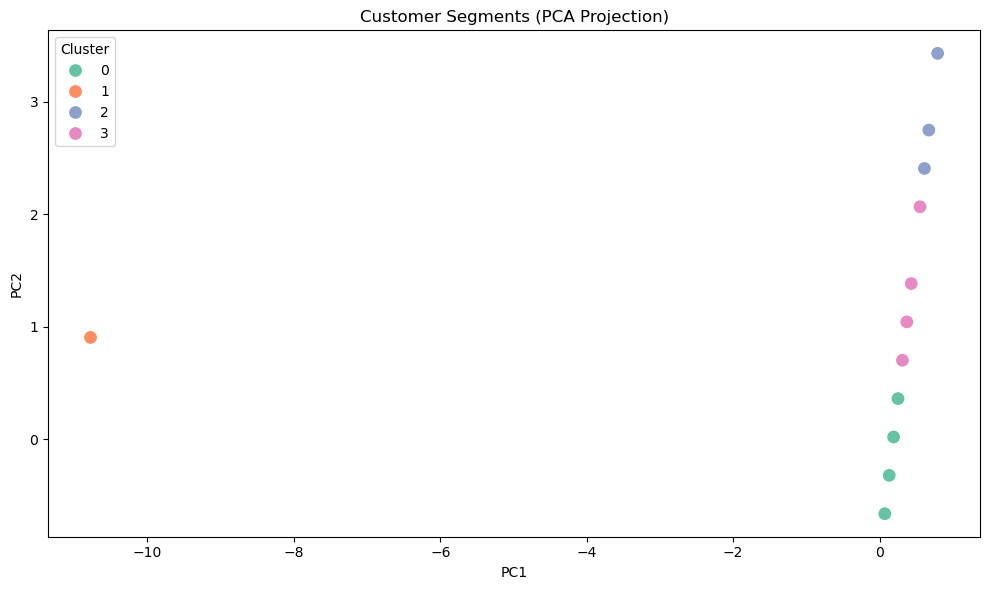


📌 Cluster Summary:

         total_invoices  total_spent  total_tracks
cluster                                           
0                   7.0        38.28          38.0
1                   6.0        36.64          36.0
2                   7.0        47.95          38.0
3                   7.0        43.62          38.0


In [13]:
# Plot clusters with PCA projection
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='Set2', s=100)
plt.title("Customer Segments (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.savefig("../images/customer_segments.png")
plt.show()

# Cluster Summary Table
cluster_summary = df_customers.groupby('cluster')[features].mean()
print("\n📌 Cluster Summary:\n")
print(cluster_summary.round(2))


📌 Cluster Summary:

                       total_invoices  total_spent  total_tracks
segment                                                         
Average Buyers                    6.0        36.64          36.0
Frequent Low Spenders             7.0        38.28          38.0
High-Value Purchasers             7.0        47.95          38.0
Track Collectors                  7.0        43.62          38.0


<Figure size 1200x600 with 0 Axes>

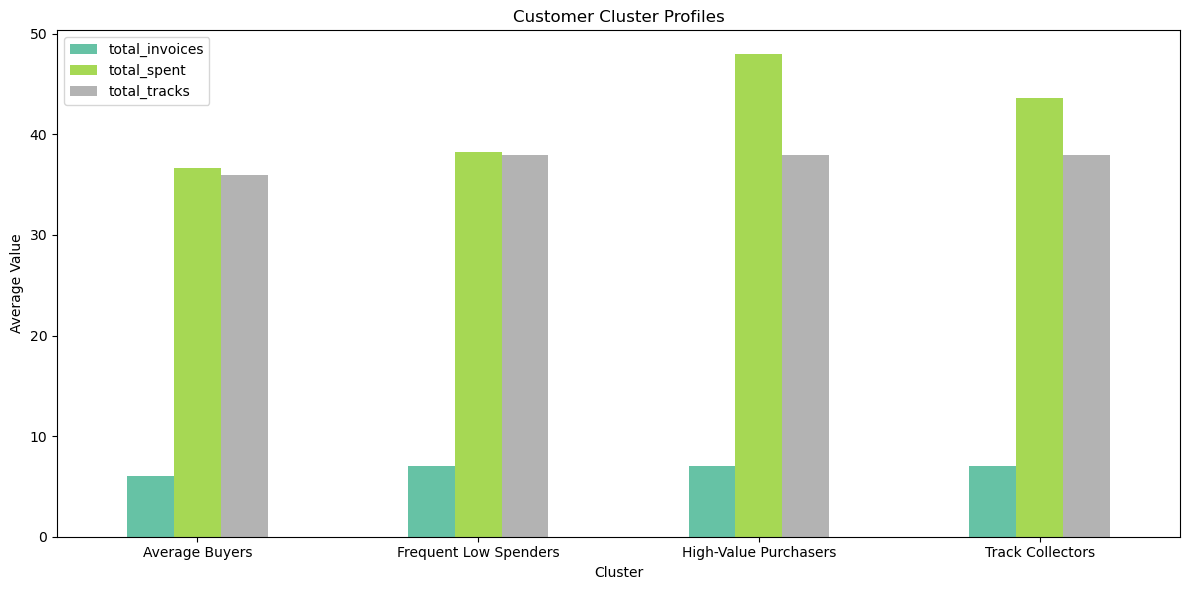

In [18]:
cluster_summary = df_customers.groupby('segment')[features].mean().round(2)
print("\n📌 Cluster Summary:\n")
print(cluster_summary)

# Cluster Summary Visualization (Barplot)
plt.figure(figsize=(12,6))
cluster_summary.plot(kind='bar', figsize=(12,6), colormap='Set2')
plt.title("Customer Cluster Profiles")
plt.xlabel("Cluster")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../images/customer_cluster_profiles.png")
plt.show()


c:\Users\User\anaconda3\envs\machinelearning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\User\anaconda3\envs\machinelearning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\User\anaconda3\envs\machinelearning\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\User\anaconda3\envs\machinelearning\Lib\site-packages\sklearn\clust

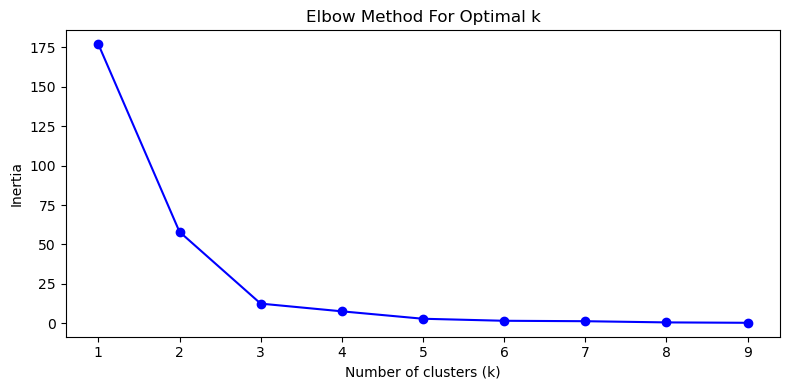

In [19]:
# Determine optimal number of clusters (Elbow method)
inertia = []
k_range = range(1, 10)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.tight_layout()
plt.savefig("../images/kmeans_elbow.png")
plt.show()

In [20]:
# 💾 Export for Power BI
output_path = Path("../data/customer_clusters.csv")
df_customers.to_csv(output_path, index=False)

### 📘 Segment Interpretation

After applying KMeans clustering on invoice frequency, total spending, and track count, four distinct customer segments were identified:

- 🤑 **High-Value Purchasers**: Customers with few invoices but high total spending. Likely purchase complete albums or premium tracks. High lifetime value.
- 🔁 **Frequent Low Spenders**: Customers who purchase often, but spend relatively little per transaction. Good candidates for upselling or loyalty programs.
- 🎼 **Track Collectors**: Customers with many tracks purchased, moderate invoices, and balanced spending. Possibly collectors or playlist curators.
- 🎯 **Average Buyers**: Balanced profile across all metrics. Represent the majority base.

These segments can help the business personalize marketing, improve retention strategies, and tailor product offerings by segment.